In [111]:
import torch
from torch.autograd.functional import hessian
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_Sigmainv, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.bayes import logPr_bayes, logPr_laplace, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from aeons.models import LS, CG, CG_naive, freq_std

In [294]:
def linear_loglike():
    def func(logx, theta):
        x = np.exp(logx)
        return theta*x
    def inverse(y, theta, torched=False):
        x = y/theta
        if torched:
            return torch.log(x)
        return np.log(x)
    def prime(logx, theta, torched=False):
        x = torch.exp(logx) if torched else np.exp(logx)
        return theta * x
    return likelihood(func, inverse, prime)

def simple_loglike():
    def func(logx, theta):
        x = np.exp(logx)
        return -x**(2/theta)
    def inverse(y, theta, torched=False):
        x = (-y)**(theta/2)
        if torched:
            return torch.log(x)
        return np.log(x)
    def prime(logx, theta, torched=False):
        x = torch.exp(logx) if torched else np.exp(logx)
        return -2/theta * x**(2/theta)
    return likelihood(func, inverse, prime)
linear_log, simple_log = linear_loglike(), simple_loglike()

In [163]:
def upper_Linv(nk):
    ndead = len(nk)
    Linv = np.zeros((ndead, ndead))
    for j in range(ndead - 1):
        Linv[j][j] = nk[j]
        Linv[j+1][j] = - nk[j+1]
    Linv[ndead - 1][ndead - 1] = nk[ndead - 1]
    return Linv

def logPr(y, likelihood, mean, covinv, theta):
    logX = likelihood.inverse(y, theta)
    return - (logX - mean).T @ covinv @ (logX - mean)

def minimise(y, likelihood, mean, covinv, x0):
    def func(theta):
        return - logPr(y, likelihood, mean, covinv, theta)
    solution = minimize(func, x0)
    return solution

### **Comparing distribution of $L (\log X - \mu)$ for the two decompositions**

(at the $\log X$ which maximises $\log \Pr$). 

$L'(\log X - \mu)$ is roughly Gaussian centred at 0 with mean 1, while $L^{-1}(\log X - \mu)$ is very much not - looks more like $\log t$ distribution, which is unexpected

Next, try to minimise the decomposed vectors individually and observe distribution again

In [164]:
nk = nk_dead(nlive=500, ndead=500)
mean_logX = logX_mu(nk)
covinv_logX = logX_Sigmainv(nk)
cov_logX = np.linalg.inv(covinv_logX)
Lprime = np.linalg.cholesky(covinv_logX)
Linv = upper_Linv(nk)

In [197]:
X = generate_Xs(nk)
logX = np.log(X)
like = simple_log
theta_true = 10
y = simple_log.func(logX, theta_true)
theta_min = minimise(y, like, mean_logX, covinv_logX, theta_true).x
logX_min = like.inverse(y, theta_min)
# plt.plot(X, y, 'x', ms=2)
# plt.plot(np.exp(logX_min), y, label=f'corr, {np.round(theta_min, 2)}')
# plt.legend();

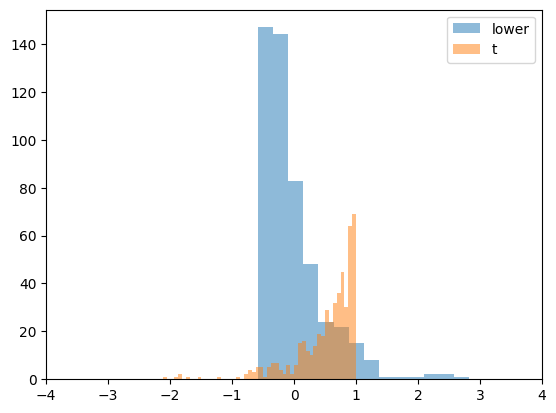

In [198]:
dev = (logX_min - mean_logX)
plt.hist(Lprime.T @ dev, bins=50, alpha=0.5, label='lower')
plt.hist(Linv @ dev, bins=50, alpha=0.5, label='t');
#plt.hist(Linv @ (logX - mean_logX), bins=50, alpha=0.5, label='true')
plt.xlim(-4, 4)
plt.legend();

### **Minimise rotated vectors directly**

In [206]:
def log_shrinkage(logX):
    shifted = np.roll(logX, 1)
    shifted[0] = 0
    return logX - shifted

def logPr_logt(y, likelihood, mean, theta):
    logX = likelihood.inverse(y, theta)
    logt = log_shrinkage(logX)
    return - np.sum((logt - mean)**2)

def minimise_logt(y, likelihood, mean, x0):
    def func(theta):
        return - logPr_logt(y, likelihood, mean, theta)
    solution = minimize(func, x0)
    return solution

In [262]:
nk = nk_dead(nlive=500, ndead=500)
mean_logX = logX_mu(nk)
covinv_logX = logX_Sigmainv(nk)
mean_logt = log_shrinkage(mean_logX)
Lprime = np.linalg.cholesky(covinv_logX)
Linv = upper_Linv(nk)

In [299]:
X = generate_Xs(nk)
logX = np.log(X)
logt = log_shrinkage(logX)
like = simple_log
theta_true = 10
y = like.func(logX, theta_true)
theta_min = minimise(y, like, mean_logX, covinv_logX, theta_true).x
logX_min = like.inverse(y, theta_min)
theta_min

array([5.02034416])

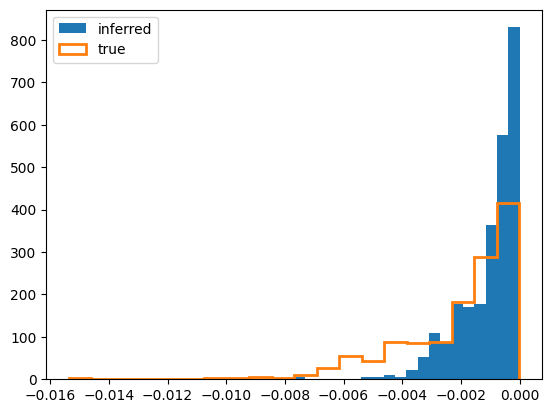

In [300]:
theta_t = minimise_logt(y, like, mean_logt, theta_true).x
logt_min = log_shrinkage(like.inverse(y, theta_t))
plt.hist(logt_min, bins=20, density=True, label='inferred');
plt.hist(logt, bins=20, histtype='step', density=True, lw=2, label='true');
plt.legend();

Don't expect Gaussian errors, since $\log t$ cannot be greater than 0. If Gaussian, would have mean $-1/n$ and standard deviation $1/n$

Shape of $\log L$ forces errors to follow a certain form - what is it?